### Vorbereitung des Datensatzes: Flüchtlingsaufnahme und wirtschaftlicher Wohlstand

Dieses Notebook dient der Zusammenführung, Prüfung und Bereinigung von Daten
zur Flüchtlingsaufnahme pro Kopf und zum Bruttoinlandsprodukt pro Kopf.
Ziel ist es, einen konsistenten und möglichst vollständigen Datensatz zu erzeugen,
der als Grundlage für die Analyse der Hypothese dient, ob wirtschaftlich
wohlhabendere Länder relativ mehr Flüchtlinge aufnehmen.


### Zusammenführung von Flüchtlings- und GDP-Daten

Die GDP-per-capita-Daten werden aufbereitet und mit dem Datensatz zur
Flüchtlingsaufnahme pro Kopf über Länderkennungen und Jahre verknüpft.
Der resultierende Datensatz kombiniert beide Informationsquellen
und wird für weitere Analysen gespeichert.


In [ ]:
import pandas as pd

gdp_path = r"../../additional_data/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_308461.csv"
gdp_raw = pd.read_csv(gdp_path, skiprows=3)

year_cols = [col for col in gdp_raw.columns if col.isdigit()]

gdp_long = gdp_raw.melt(
    id_vars=["Country Name", "Country Code"],
    value_vars=year_cols,
    var_name="Year",
    value_name="GDP_per_capita"
)

gdp_long["Year"] = pd.to_numeric(gdp_long["Year"], errors="coerce").astype("Int64")

refugee_new_path = r"../../output_csv_files/Destination_refugees_per_capita.csv"
ref_new = pd.read_csv(refugee_new_path)

ref_new["Year"] = pd.to_numeric(ref_new["Year"], errors="coerce").astype("Int64")

print(ref_new.head())

merged_final = pd.merge(
    ref_new,
    gdp_long[["Country Code", "Year", "GDP_per_capita"]],
    left_on=["country_code", "Year"],   
    right_on=["Country Code", "Year"], 
    how="left"
)

print("Merged shape:", merged_final.shape)
print(merged_final.head())

output_path = (
    r"../../output_csv_files/"
    "Destination_refugees_per_capita_with_gdp.csv"
)
merged_final.to_csv(output_path, index=False)

print("Saved:", output_path)


       country  Year  Refugee_amount country_code  Population  refugee_share  \
0  Afghanistan  1990            50.0          AFG  12045660.0       0.000004   
1  Afghanistan  1991            38.0          AFG  12238879.0       0.000003   
2  Afghanistan  1992         60025.0          AFG  13278974.0       0.004520   
3  Afghanistan  1993         32132.0          AFG  14943172.0       0.002150   
4  Afghanistan  1994         19131.0          AFG  16250794.0       0.001177   

   share_per_1000  
0        0.004151  
1        0.003105  
2        4.520304  
3        2.150280  
4        1.177235  
Merged shape: (6063, 9)
       country  Year  Refugee_amount country_code  Population  refugee_share  \
0  Afghanistan  1990            50.0          AFG  12045660.0       0.000004   
1  Afghanistan  1991            38.0          AFG  12238879.0       0.000003   
2  Afghanistan  1992         60025.0          AFG  13278974.0       0.004520   
3  Afghanistan  1993         32132.0          AFG  1494

### Analyse fehlender Werte

Der kombinierte Datensatz wird geladen und mithilfe einer Heatmap
wird visualisiert, in welchen Spalten und Beobachtungen fehlende Werte auftreten.
Dies dient der qualitativen Kontrolle der Daten vor weiteren Bereinigungsschritten.


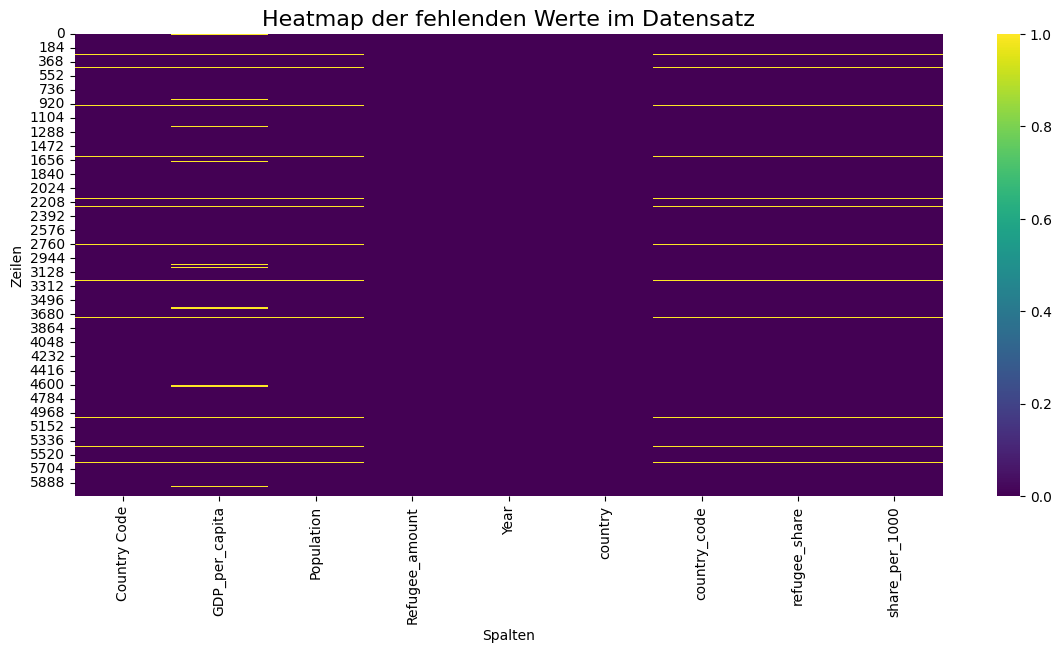

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

path = r"../../output_csv_files/Destination_refugees_per_capita_with_gdp.csv"
df = pd.read_csv(path)

df = df.sort_index(axis=1)

plt.figure(figsize=(14, 6))
sns.heatmap(df.isna(), cbar=True, cmap="viridis")

plt.title("Heatmap der fehlenden Werte im Datensatz", fontsize=16)
plt.xlabel("Spalten")
plt.ylabel("Zeilen")
plt.show()




Der Datensatz wird auf Beobachtungen ab dem Jahr 1970 beschränkt,
um frühe Jahre mit unvollständigen Daten auszuschließen.
Anschließend wird die Verteilung fehlender Werte erneut visualisiert.


(5595, 9)


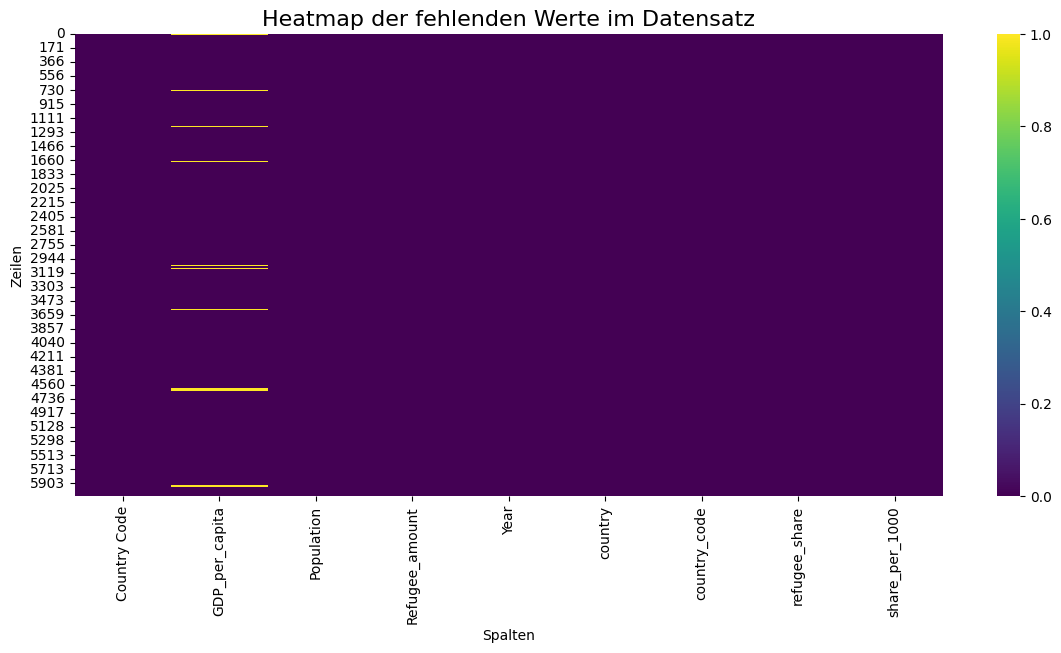

In [ ]:
df_clean = df[df["Year"] >= 1970].copy()

print(df_clean.shape)
df_clean.head()


plt.figure(figsize=(14, 6))
sns.heatmap(df_clean.isna(), cbar=True, cmap="viridis")

plt.title("Heatmap der fehlenden Werte im Datensatz", fontsize=16)
plt.xlabel("Spalten")
plt.ylabel("Zeilen")
plt.show()



Für jede Variable wird die Anzahl und der prozentuale Anteil
fehlender Werte berechnet und übersichtlich zusammengefasst,
um problematische Spalten gezielt identifizieren zu können.


In [ ]:
nan_report = pd.DataFrame({
    "missing_count": df_clean.isna().sum(),
    "missing_percent": df_clean.isna().mean() * 100
}).sort_values("missing_percent", ascending=False)

nan_report


,missing_count,missing_percent
GDP_per_capita,132,2.359249
Country Code,0,0.000000
Population,0,0.000000
Refugee_amount,0,0.000000
Year,0,0.000000
country,0,0.000000
country_code,0,0.000000
refugee_share,0,0.000000
share_per_1000,0,0.000000


Es wird geprüft, für welche Länder über alle betrachteten Jahre hinweg
keine GDP-per-capita-Daten vorhanden sind. Diese Länder können in der
weiteren Analyse nicht berücksichtigt werden.


In [ ]:
missing_total = df_clean["GDP_per_capita"].isna().sum()
missing_percent = df_clean["GDP_per_capita"].isna().mean() * 100

print("Fehlende GDP-Werte:", missing_total)
print(f"Anteil fehlender GDP-Werte: {missing_percent:.2f}%")

missing_by_country = (
    df_clean[df_clean["GDP_per_capita"].isna()]
    .groupby("country")
    .size()
    .sort_values(ascending=False)
)

print("\nFehlende GDP-Werte pro Land:")
print(missing_by_country)

countries_no_gdp = (
    df_clean.groupby("country")["GDP_per_capita"]
    .apply(lambda x: x.isna().all())
)

print("\nLänder ohne verfügbare GDP-Daten:")
print(countries_no_gdp[countries_no_gdp])


Fehlende GDP-Werte: 132
Anteil fehlender GDP-Werte: 2.36%

Fehlende GDP-Werte pro Land:
country
Serbia and Kosovo (S/RES/1244 (1999))    25
Mozambique                               16
Lebanon                                  15
Viet Nam                                 11
Lao People's Dem. Rep.                   10
Djibouti                                  9
Afghanistan                               8
Romania                                   8
China, Macao SAR                          7
British Virgin Islands                    6
Eritrea                                   5
Angola                                    4
Cyprus                                    3
Venezuela (Bolivarian Republic of)        2
Cambodia                                  1
Dem. People's Rep. of Korea               1
South Sudan                               1
dtype: int64

Länder ohne verfügbare GDP-Daten:
country
British Virgin Islands         True
Dem. People's Rep. of Korea    True
Name: GDP_per_capita, dtype:

Im aufbereiteten Datensatz fehlen insgesamt 132 GDP-per-capita-Werte, was einem Anteil von lediglich **2.38 %** aller Beobachtungen entspricht. Der überwiegende Teil der Daten ist somit vollständig verfügbar, sodass die Analyse insgesamt auf einer stabilen Datenbasis beruht.

Eine länderspezifische Auswertung der fehlenden Werte zeigt, dass die fehlenden GDP-Daten größtenteils auf wenige Länder konzentriert sind. Für die Einheit *Serbia and Kosovo (S/RES/1244 (1999))* treten besonders viele fehlende Werte auf, da diese politische Einheit ab dem Jahr 1999 nicht mehr fortgeführt wird und somit im Analysezeitraum keine konsistenten GDP-Daten mehr vorliegen. Aus diesem Grund wurde diese Einheit vollständig aus dem Datensatz entfernt.

Darüber hinaus wurden die Länder *British Virgin Islands* und *Dem. People's Rep. of Korea* vollständig ausgeschlossen, da für diese Länder im betrachteten Zeitraum keinerlei GDP-per-capita-Daten verfügbar sind.

Alle übrigen Länder wurden im Datensatz belassen, da dort fehlende GDP-Werte nur punktuell auftreten und keinen systematischen Ausfall über den gesamten Analysezeitraum darstellen. Dieses Vorgehen erlaubt es, möglichst viele Länder in die Analyse einzubeziehen, ohne die statistische Aussagekraft und Vergleichbarkeit der Ergebnisse wesentlich zu beeinträchtigen.


In [ ]:
countries_to_remove = [
    "British Virgin Islands",
    "Dem. People's Rep. of Korea",
    "Serbia and Kosovo (S/RES/1244 (1999))",
]

print("\nEntfernte Länder:")
for c in countries_to_remove:
    print("-", c)

rows_before = df_clean.shape[0]
df_final = df_clean[~df_clean["country"].isin(countries_to_remove)].copy()
df_final = df_final.dropna(subset=["GDP_per_capita"])
rows_after = df_final.shape[0]

print("\nZeilen vor Cleaning:", rows_before)
print("Zeilen nach Cleaning:", rows_after)
print("Entfernte Zeilen:", rows_before - rows_after)



Entfernte Länder:
- British Virgin Islands
- Dem. People's Rep. of Korea
- Serbia and Kosovo (S/RES/1244 (1999))

Zeilen vor Cleaning: 5595
Zeilen nach Cleaning: 5441
Entfernte Zeilen: 154


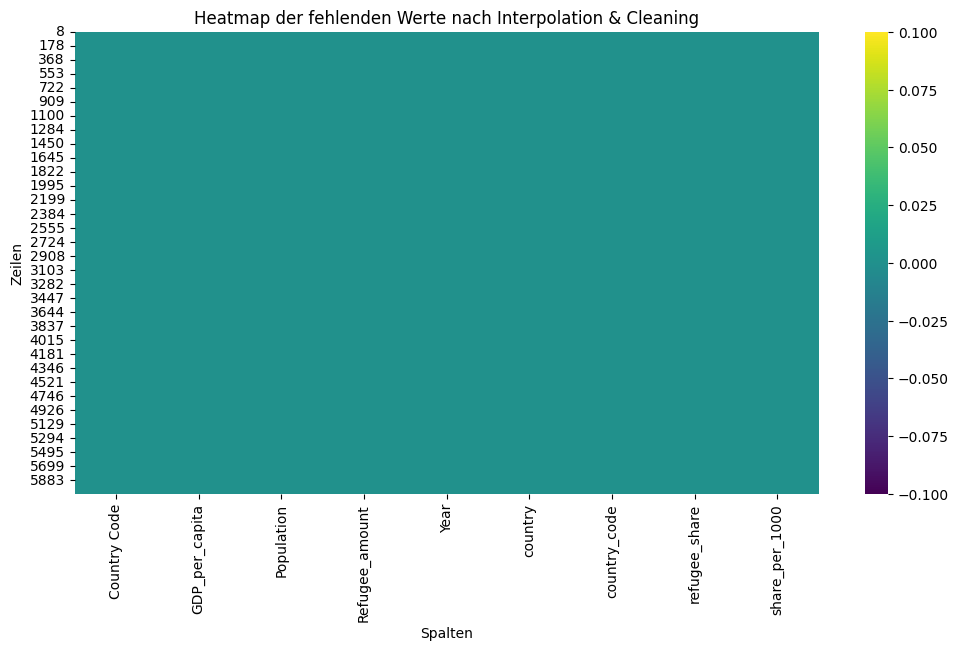

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(df_final.isna(), cbar=True, cmap="viridis")
plt.title("Heatmap der fehlenden Werte nach Interpolation & Cleaning")
plt.xlabel("Spalten")
plt.ylabel("Zeilen")
plt.show()


In [ ]:
output_path = r"../../output_csv_files/Destination_refugees_per_capita_with_gdp_cleaned.csv"

df_final.to_csv(output_path, index=False)

print("Gespeichert unter:", output_path)


Gespeichert unter: ../../output_csv_files/Destination_refugees_per_capita_with_gdp_cleaned.csv
